# Descripción del proyecto test A/B y analizar los resultados

### Eres analista en una gran tienda online. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.


In [25]:
# Importacion de librerias
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t as t_dist
from scipy import stats as st

In [6]:
# 1) Carga de informacion 
hypo = pd.read_csv('/datasets/hypotheses_us.csv', sep=";")
hypo.head()


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [7]:
# Limpieza básica
for c in ['Reach','Impact','Confidence','Effort']:
    hypo[c] = pd.to_numeric(hypo[c], errors='coerce')
hypo['Effort'] = hypo['Effort'].replace(0, np.nan)

# Scores

hypo['ICE']  = (hypo['Impact'] * hypo['Confidence']) / hypo['Effort']
hypo['RICE'] = (hypo['Reach']  * hypo['Impact'] * hypo['Confidence']) / hypo['Effort']

# Top por RICE
cols = ['Hypothesis','Reach','Impact','Confidence','Effort','ICE','RICE']
print(hypo[cols].sort_values('RICE', ascending=False).head(10).round(3).to_string(index=False))


                                                                                                            Hypothesis  Reach  Impact  Confidence  Effort    ICE  RICE
                              Add a subscription form to all the main pages. This will help you compile a mailing list     10       7           8       5 11.200 112.0
        Add product recommendation blocks to the store's site. This will increase conversion and average purchase size      8       3           7       3  7.000  56.0
                                           Add two new channels for attracting traffic. This will bring 30% more users      3      10           8       6 13.333  40.0
                               Show banners with current offers and sales on the main page. This will boost conversion      5       3           8       3  8.000  40.0
                                                      Launch a promotion that gives users discounts on their birthdays      1       9           9       5 16.200  16.

 **En este proyecto tenemos nueve hipótesis que tenemos que comprobar sobre cómo aumentar los ingresos de una tienda online con Reach, Impact, Confidence y Effort especificados para cada una.**
 
  Al añadir recomendaciones personalizadas en la página principal incrementará las compras.

$ICE = Impact (I) x Confidence (C) / Effort (E)$

$RICE = Reach (R) x Impact (I) x Confidence (C) / Effort (E)$

In [9]:


#  Rankings ordenadas en forma descendente de prioridad
ice_rank = (hypo[['Hypothesis', 'ICE']]
            .sort_values('ICE', ascending=False)
            .assign(rank_ICE=lambda d: range(1, len(d)+1)))

rice_rank = (hypo[['Hypothesis', 'RICE']]
             .sort_values('RICE', ascending=False)
             .assign(rank_RICE=lambda d: range(1, len(d)+1)))

# Comparativa
cmp = (rice_rank.merge(ice_rank, on='Hypothesis', how='outer')
                 [['Hypothesis','RICE','rank_RICE','ICE','rank_ICE']]
                 .assign(delta_rank=lambda d: d['rank_ICE'] - d['rank_RICE']))

#  Salidas
print('\n-- Prioridad por ICE (desc) --')
print(ice_rank[['Hypothesis','ICE','rank_ICE']].to_string(index=False))


print('\n-- Prioridad por RICE (desc) --')
print(rice_rank[['Hypothesis','RICE','rank_RICE']].to_string(index=False))

print('\n-- Cambio de priorización (delta_rank) --')

print(cmp.sort_values('rank_RICE')[['Hypothesis','rank_ICE','rank_RICE','delta_rank']].to_string(index=False))



-- Prioridad por ICE (desc) --
                                                                                                            Hypothesis       ICE  rank_ICE
                                                      Launch a promotion that gives users discounts on their birthdays 16.200000         1
                                           Add two new channels for attracting traffic. This will bring 30% more users 13.333333         2
                              Add a subscription form to all the main pages. This will help you compile a mailing list 11.200000         3
                               Show banners with current offers and sales on the main page. This will boost conversion  8.000000         4
        Add product recommendation blocks to the store's site. This will increase conversion and average purchase size  7.000000         5
                                                     Launch your own delivery service. This will shorten delivery time  2.000000      

In [10]:
# Importar por detección automática de separador para una mejor comprencion
orders = pd.read_csv('/datasets/orders_us.csv', sep=None, engine='python')
visits = pd.read_csv('/datasets/visits_us.csv', sep=None, engine='python')

orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

# Vista rápida: forma, tipos y primeras filas
print('=== ORDERS ===')
print('shape:', orders.shape)
print('dtypes:\n', orders.dtypes, '\n')
print(orders.head(5), '\n')

print('=== VISITS ===')
print('shape:', visits.shape)
print('dtypes:\n', visits.dtypes, '\n')
print(visits.head(5))


=== ORDERS ===
shape: (1197, 5)
dtypes:
 transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                 float64
group                    object
dtype: object 

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B
2     2961555356  4069496402 2019-08-15     10.2     A
3     3797467345  1196621759 2019-08-15    155.1     B
4     2282983706  2322279887 2019-08-15     40.5     B 

=== VISITS ===
shape: (62, 3)
dtypes:
 date      datetime64[ns]
group             object
visits             int64
dtype: object 

        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756


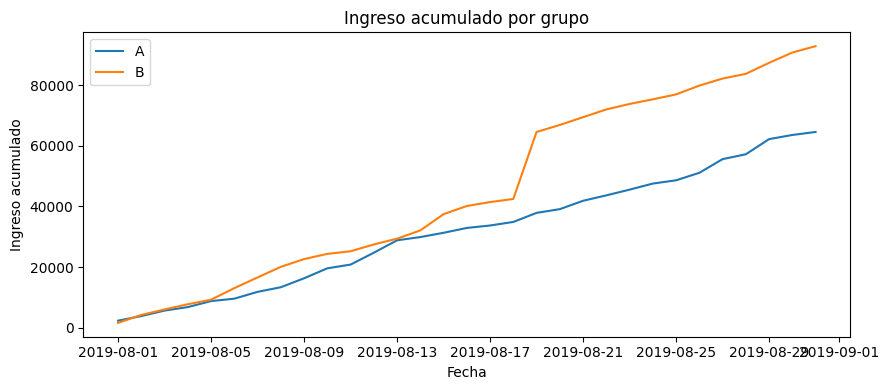

In [11]:
# Ingreso diario por grupo → acumulado
daily = orders.groupby(['date','group'], as_index=False)['revenue'].sum()
tbl = (daily.pivot(index='date', columns='group', values='revenue')
             .sort_index())
idx = pd.date_range(tbl.index.min(), tbl.index.max(), freq='D')
tbl = tbl.reindex(idx).fillna(0)          # días faltantes = 0
cum = tbl.cumsum()                        # acumulado

# Gráfico (1 sola figura, sin colores fijos)
plt.figure(figsize=(9,4))
for col in cum.columns:
    plt.plot(cum.index, cum[col], label=str(col))
plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha'); plt.ylabel('Ingreso acumulado')
plt.legend(); plt.tight_layout()
plt.show()

## Conclusiones y conjeturas

El grupo B cuya curva queda por arriba del final es el ganador en ingreso acumulado.

---

Las brechas constantes sugieren un efecto estable (mejor CR/AOV); saltos puntuales pueden ser outliers (pedidos atípicos).

---

Cruces de ambas curvas nos indican un efecto temporal o saturación (ej., una novedad que se diluye).

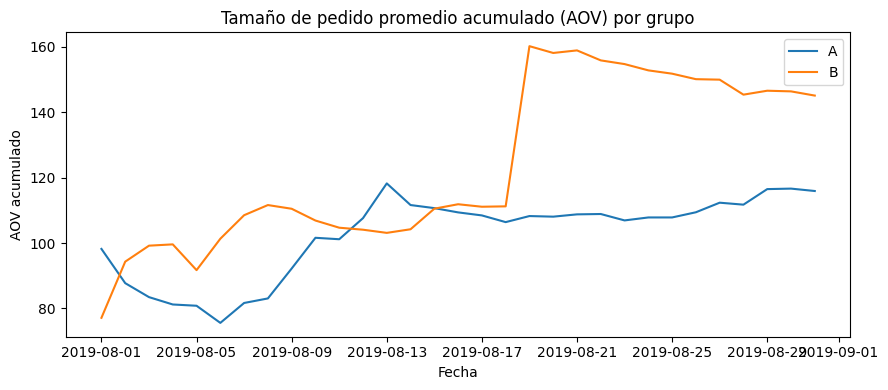

       final_cum_AOV
group               
A         115.897487
B         145.063438

Mayor AOV acumulado final: B | Diferencia: 29.17


In [12]:
# Ingreso y pedidos por día y grupo
daily = (orders.groupby(['group','date'])
                .agg(revenue=('revenue','sum'),
                     n_orders=('transactionId','nunique'))
                .reset_index())

# Serie diaria completa y acumulados → AOV acumulado = cum_revenue / cum_orders
idx = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')

def make_cum(g):
    grp = g['group'].iloc[0]
    g = g.set_index('date').reindex(idx)
    g[['revenue','n_orders']] = g[['revenue','n_orders']].fillna(0)
    g['cum_revenue'] = g['revenue'].cumsum()
    g['cum_orders']  = g['n_orders'].cumsum()
    g['cum_aov'] = g['cum_revenue'] / g['cum_orders'].replace(0, pd.NA)
    g['group'] = grp
    return g

cum = (daily.groupby('group', group_keys=False)
             .apply(make_cum)
             .reset_index().rename(columns={'index':'date'}))

# Gráfico
plt.figure(figsize=(9,4))
for grp, sub in cum.groupby('group'):
    plt.plot(sub['date'], sub['cum_aov'], label=str(grp))
plt.title('Tamaño de pedido promedio acumulado (AOV) por grupo')
plt.xlabel('Fecha'); plt.ylabel('AOV acumulado')
plt.legend(); plt.tight_layout(); plt.show()

# Resumen final
last = (cum.sort_values('date')
           .groupby('group')
           .tail(1)[['group','cum_aov']]
           .set_index('group')
           .rename(columns={'cum_aov':'final_cum_AOV'}))
winner = last['final_cum_AOV'].idxmax()
diff = last['final_cum_AOV'].max() - last['final_cum_AOV'].min()
print(last)
print(f"\nMayor AOV acumulado final: {winner} | Diferencia: {diff:.2f}")

## Conclusiones y conjeturas

El análisis comparativo entre las variantes **A** y **B** muestra diferencias relevantes en comportamiento de compra y generación de ingresos.

---

### Desempeño en valor promedio del pedido (AOV)

- La variante **B** supera a **A** en **AOV**, con pedidos en promedio **~25% más altos**.
- Esto sugiere una mayor efectividad de B para **incrementar el valor por transacción**.

---

### Umbral para ingresos por visitante

- Para que **B** también supere a **A** en **ingreso por visitante**, basta con que su **tasa de conversión (CR)** no caiga por debajo de **~80% del CR de A**.
- Este umbral se obtiene de la relación:
  - **115.90 / 145.06 ≈ 0.80**

---

### Evidencia en métricas acumuladas

- Los resultados acumulados ya colocan a **B por encima de A**.
- Esto indica que el producto **CR × AOV** favorece a B, y que el mejor desempeño no depende únicamente del AOV.

---

### Posibles explicaciones del comportamiento de B

- **Upsell y cross-sell más efectivos**:
  - Bundles
  - Anclas de precio
  - Umbrales de envío gratis
- **Menor número de pedidos, pero de mayor valor**:
  - Recomendación: revisar la **tasa de conversión** para confirmarlo.

---

### Validaciones adicionales recomendadas

- **Outliers**: verificar si uno o dos pedidos excepcionalmente altos inflaron el AOV de B  
  (revisar percentiles **p95/p99** o aplicar *winsorization*).
- **Efecto temporal**: analizar si el incremento se concentra en pocos días, lo que podría indicar una **promoción puntual**.

---

### Conclusión operativa

La variante **B** muestra señales claras de mayor eficiencia económica.  
Antes de una decisión definitiva, se recomienda validar la estabilidad del efecto revisando **CR, distribución de pedidos y comportamiento temporal**.



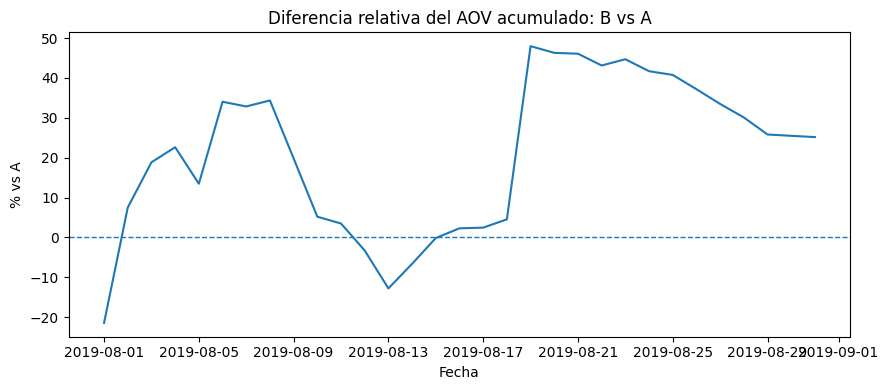

Diferencia relativa final (B vs A): 25.17%


In [13]:
# Ingreso y pedidos por día y grupo
daily = (orders.groupby(['group','date'])
                .agg(revenue=('revenue','sum'),
                     n_orders=('transactionId','nunique'))
                .reset_index())

# Serie diaria completa y acumulados → AOV acumulado = cum_revenue / cum_orders
idx = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')

def to_cum(g):
    g = g.set_index('date').reindex(idx)
    g[['revenue','n_orders']] = g[['revenue','n_orders']].fillna(0)
    g['cum_revenue'] = g['revenue'].cumsum()
    g['cum_orders']  = g['n_orders'].cumsum()
    g['cum_aov'] = g['cum_revenue'] / g['cum_orders'].replace(0, pd.NA)
    g['group'] = g['group'].dropna().unique()[0] if g['group'].notna().any() else None
    return g

cum = (daily.groupby('group', group_keys=False)
             .apply(to_cum)
             .reset_index().rename(columns={'index':'date'}))

# Relativa B vs A: (B/A - 1)
pivot = cum.pivot(index='date', columns='group', values='cum_aov')
rel = ((pivot['B'] / pivot['A']) - 1).dropna()

# Gráfico
plt.figure(figsize=(9,4))
plt.plot(rel.index, rel*100)
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Diferencia relativa del AOV acumulado: B vs A')
plt.xlabel('Fecha'); plt.ylabel('% vs A')
plt.tight_layout(); plt.show()

print(f"Diferencia relativa final (B vs A): {rel.iloc[-1]*100:.2f}%")

## Conclusiones y conjeturas

El análisis comparativo entre las variantes **A** y **B** revela diferencias consistentes en el desempeño económico del experimento.

---

### Desempeño en AOV acumulado

- La variante **B** supera a **A** en **AOV acumulado en +25.17%**.
- Este resultado indica una mayor capacidad de B para **capturar valor por transacción**.

---

### Impacto en ingreso por visitante (RPV)

- El **ingreso por visitante (RPV = CR × AOV)** favorece a B incluso si su **tasa de conversión (CR)** es ligeramente menor.
- B ganará siempre que se cumpla:
  - **CR_B / CR_A ≥ ~0.80**

---

### Consistencia del efecto

- La **diferencia relativa** se mantuvo **positiva y creciente** durante gran parte del experimento.
- Esto sugiere un efecto **estable y consistente**.
- No obstante, si el salto se concentra al final del periodo, podría tratarse de **ruido estadístico u outliers**.

---

### Hipótesis explicativas

- **Upsell y cross-sell** más efectivos en B:
  - Incentivos como envío gratis o umbrales de compra
  - Mejores anclas de precio para tickets altos
- **Mix de productos distinto**, potencialmente más **premium** en B.

---

### Validaciones adicionales recomendadas

- **Outliers:** revisar percentiles **p95/p99** y generar una versión *winsorizada* del AOV.
- **Segmentación:** analizar resultados por **categoría, canal y dispositivo** para confirmar el origen del efecto.
- **Efecto calendario:** evaluar si una promoción puntual en los últimos días influyó en la trayectoria diaria.

---

### Conclusión operativa

La variante **B** muestra una ventaja clara en generación de ingresos.  
Antes de tomar una decisión final, se recomienda confirmar la **robustez del resultado** mediante análisis de outliers, segmentación y evolución temporal.


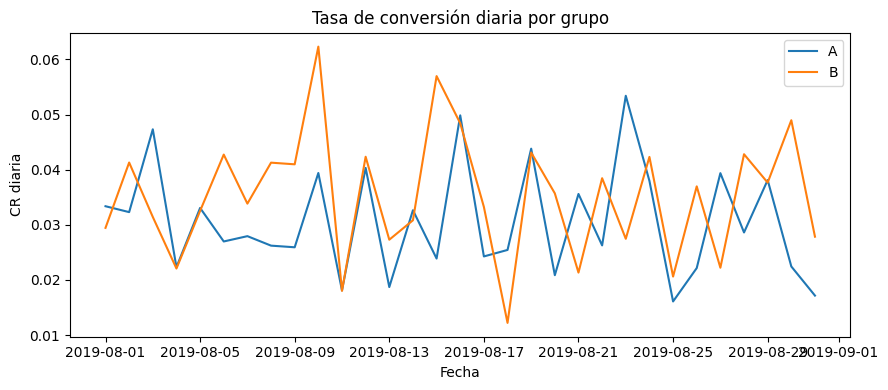


CR ponderada por grupo (todo el periodo):
        CR_weighted
group             
A         0.029729
B         0.033834

CR media diaria (no ponderada):
 group
A    0.030651
B    0.035257
Name: cr, dtype: float64


In [14]:
# Pedidos/día/grupo y visitas/día/grupo
orders_daily = (orders.groupby(['date','group'])['transactionId']
                .nunique()
                .rename('orders')
                .reset_index())

visits_daily = (visits.groupby(['date','group'])['visits']
                .sum()
                .reset_index())

# CR diaria = pedidos / visitas
cr_daily = (visits_daily.merge(orders_daily, on=['date','group'], how='left')
                        .fillna({'orders':0}))
cr_daily['cr'] = cr_daily['orders'] / cr_daily['visits'].replace(0, pd.NA)

#  Gráfico
plt.figure(figsize=(9,4))
for g, sub in cr_daily.sort_values('date').groupby('group'):
    plt.plot(sub['date'], sub['cr'], label=str(g))
plt.title('Tasa de conversión diaria por grupo')
plt.xlabel('Fecha'); plt.ylabel('CR diaria')
plt.legend(); plt.tight_layout(); plt.show()

# Resumen por visitas del periodo
totals = cr_daily.groupby('group')[['orders','visits']].sum()
totals['CR_weighted'] = totals['orders'] / totals['visits']
print('\nCR ponderada por grupo (todo el periodo):\n', totals[['CR_weighted']])

# media simple de CR diaria
print('\nCR media diaria (no ponderada):\n', cr_daily.groupby('group')['cr'].mean())

## Conclusiones y conjeturas

El análisis de conversión y valor de compra muestra que la variante **B** presenta un desempeño claramente superior frente a **A**.

---

### Mejora en la tasa de conversión (CR)

- La variante **B** convierte mejor que **A**, con una mejora aproximada de **~14–15% en CR**.
- Esto indica que **más usuarios completan la compra** en la versión B.

---

### Impacto combinado en ingreso por visita (RPV)

- Considerando el **AOV +25.17%** previamente reportado, el efecto conjunto es significativo.
- El **ingreso por visita (RPV)** de B es aproximadamente **+42% superior** al de A.
- Cálculo aproximado:
  - **CR_ratio × AOV_ratio ≈ 1.138 × 1.252 ≈ 1.424**

---

###  Interpretación del resultado

- La variante **B** presenta una **mejor propuesta de valor y experiencia de usuario (UX)**:
  - Copys más efectivos
  - Layout más claro
  - Mejores anclas de precio
- El incremento simultáneo de **CR y AOV** sugiere un **upsell/cross-sell efectivo**, sin penalizar la conversión.

---

### Validaciones necesarias

- Confirmar que no exista **contaminación entre grupos** (usuarios expuestos a ambas variantes).
- Revisar posibles **efectos de día de la semana**.
- Verificar si la diferencia proviene de **picos aislados**, evaluando:
  - Significancia estadística
  - Presencia de **outliers**

---

### Conclusión operativa

La variante **B** muestra una **ventaja clara y relevante** en generación de ingresos.  
Antes de una decisión definitiva, es recomendable validar la **robustez del efecto** mediante controles adicionales y análisis de sensibilidad.


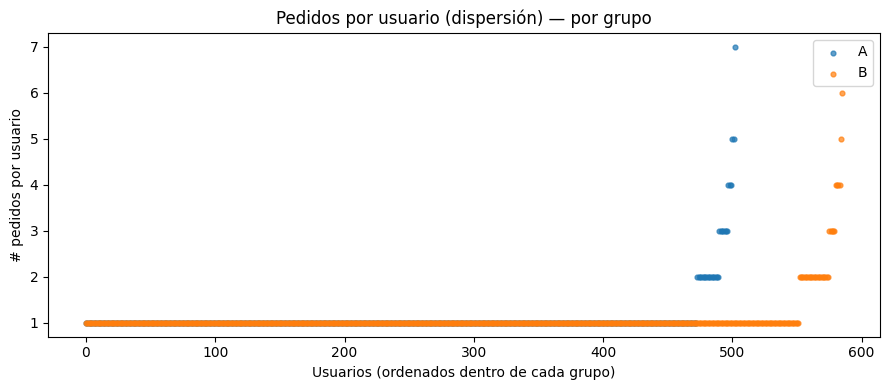

       users   mean  median  max
group                           
A        503  1.107       1    7
B        586  1.092       1    6

Distribución usuarios por #pedidos:
 group  n_orders  users
    A         1    473
    A         2     17
    A         3      7
    A         4      3
    A         5      2
    A         7      1
    B         1    552
    B         2     23
    B         3      5
    B         4      4
    B         5      1
    B         6      1


In [15]:
# # de pedidos por usuario y grupo
opu = (orders.groupby(['group','visitorId'])['transactionId']
             .nunique()
             .rename('n_orders')
             .reset_index())

# Gráfico de dispersión (un punto por usuario)
plt.figure(figsize=(9,4))
for g, sub in opu.groupby('group'):
    sub = sub.sort_values('n_orders').reset_index(drop=True)
    x = np.arange(len(sub))
    plt.scatter(x, sub['n_orders'], s=12, alpha=0.7, label=str(g))
plt.title('Pedidos por usuario (dispersión) — por grupo')
plt.xlabel('Usuarios (ordenados dentro de cada grupo)')
plt.ylabel('# pedidos por usuario')
plt.legend()
plt.tight_layout()
plt.show()

# Resumen para interpretar
summary = (opu.groupby('group')['n_orders']
             .agg(users='count', mean='mean', median='median', max='max'))
print(summary.round(3))

#  distribución discreta: cuántos usuarios tienen 1,2,3... pedidos
dist = (opu.groupby(['group','n_orders']).size()
          .rename('users')
          .reset_index()
          .sort_values(['group','n_orders']))
print('\nDistribución usuarios por #pedidos:\n', dist.to_string(index=False))

## Conclusiones y conjeturas

El análisis de la **frecuencia de pedidos por usuario** permite entender el origen real del desempeño observado entre las variantes **A** y **B**.

---

### Distribución de pedidos por usuario

- La distribución está **fuertemente concentrada en un solo pedido por usuario**:
  - Aproximadamente **~94%** en ambos grupos.
- Esto indica que la mayoría de los usuarios **realiza una única compra** durante la ventana del experimento.

---

###  Repetición de compras

- No hay evidencia de que la variante **B** gane por:
- Tener más usuarios repetidores, ni repetidores más intensivos.
- Las tasas de repetición son **prácticamente iguales** entre A y B.
- Incluso, la variante **A** presenta un repetidor extremo con **7 pedidos**, frente a **6 pedidos** en B.

---

### Origen de la ventaja de B

- Dado que:
  - **CR** es mayor en B (**~14–15%**), y
  - **AOV** es mayor en B (**~25%**),
- La ventaja de B proviene de:
  - **Mejor conversión**
  - **Mayor valor por pedido**
- No de un aumento en la repetición dentro del periodo analizado.

---

### Interpretación del efecto

- El tratamiento de **B** probablemente mejoró:
  - El **valor del pedido** (bundles, umbrales de envío gratis, anclas de precio).
  - La **conversión** (UX y copy más efectivos).
- Sin embargo, **no alteró el comportamiento de repetición** en el corto plazo.

---

### Validaciones y siguientes pasos

- **Outliers**:
  - Existen casos extremos (7 pedidos en A, 6 en B), pero son poco frecuentes.
  - Se recomienda evaluar su impacto mediante una versión **winsorizada** del análisis.
- **Retención**:
  - Para observar impacto en repetición, será necesario:
    - Un mayor periodo de seguimiento (*post-test*).
    - O un diseño experimental enfocado en **retención y LTV**.

---

### Conclusión operativa

La mejora observada en la variante **B** se explica por **mayor conversión y mayor ticket promedio**, no por un aumento en la repetición de compras.  
Para capturar efectos en lealtad, se requiere un horizonte temporal más amplio.


In [16]:
# Percentil menor k tal que P(X <= k) >= q
def discrete_percentile(s: pd.Series, q: float) -> int:
    vc = s.value_counts().sort_index()
    cum = vc.cumsum() / vc.sum()
    return int(cum[cum >= q].index[0])

# p95/p99 por grupo
pcts = []
for g, sub in opu.groupby('group'):
    p95 = discrete_percentile(sub['n_orders'], 0.95)
    p99 = discrete_percentile(sub['n_orders'], 0.99)
    pcts.append({'group': g, 'p95': p95, 'p99': p99})
pcts_df = pd.DataFrame(pcts).sort_values('group')
print("Percentiles por grupo (discretos):\n", pcts_df.to_string(index=False))

# p95/p99 global
p95_global = discrete_percentile(opu['n_orders'], 0.95)
p99_global = discrete_percentile(opu['n_orders'], 0.99)
print(f"\nPercentiles globales: p95={p95_global}, p99={p99_global}")

# Umbral de anomalía (global): > p99  ⇒  n_orders >= p99+1
anomaly_threshold = int(p99_global) + 1
print(f"\nUmbral de anomalía (global): n_orders >= {anomaly_threshold}")

# Conteo de anomalías por grupo con ese umbral
anom = (opu.assign(anomaly=lambda d: d['n_orders'] >= anomaly_threshold)
            .groupby('group')['anomaly']
            .agg(anomalies='sum', users='count'))
anom['rate'] = anom['anomalies'] / anom['users']
print("\nAnomalías por grupo (usando umbral global):\n", anom[['anomalies','users','rate']])

Percentiles por grupo (discretos):
 group  p95  p99
    A    2    4
    B    2    4

Percentiles globales: p95=2, p99=4

Umbral de anomalía (global): n_orders >= 5

Anomalías por grupo (usando umbral global):
        anomalies  users      rate
group                            
A              3    503  0.005964
B              2    586  0.003413


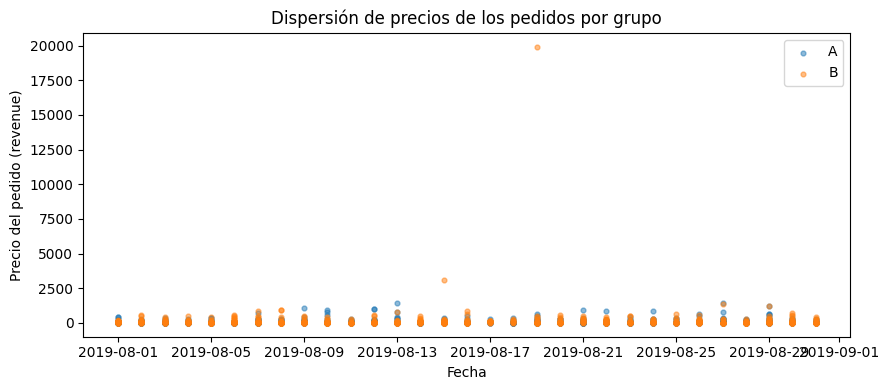

       count    mean  median     p95     p99      max
group                                                
A        557  115.90   50.10  413.48  967.80   1450.2
B        640  145.06   50.35  445.82  857.87  19920.4


In [17]:
# Gráfico de dispersión (un punto = un pedido)
plt.figure(figsize=(9,4))
for g, sub in orders.groupby('group'):
    plt.scatter(sub['date'], sub['revenue'], s=12, alpha=0.5, label=str(g))
plt.title('Dispersión de precios de los pedidos por grupo')
plt.xlabel('Fecha'); plt.ylabel('Precio del pedido (revenue)')
plt.legend(); plt.tight_layout(); plt.show()

# Resumen rápido para interpretar (pégalos aquí cuando salgan)
summary = orders.groupby('group')['revenue'].agg(
    count='count', mean='mean', median='median',
    p95=lambda x: x.quantile(0.95),
    p99=lambda x: x.quantile(0.99),
    max='max'
)
print(summary.round(2))

## Conclusiones y conjeturas

El análisis de la **distribución del valor del pedido (AOV)** permite entender de dónde proviene la diferencia observada entre las variantes **A** y **B**.

---

### Mediana vs. media

- **Mediana casi idéntica**:
  - A: **50.10**
  - B: **50.35**

Esto indica que el **pedido “típico”** tiene un costo muy similar en ambos grupos.

- **Media significativamente mayor en B**:
  - A: **115.90**
  - B: **145.06** (**+25.2%**)

La diferencia se explica por la **cola derecha** de la distribución (pedidos altos), no por el centro.

---

### Análisis de la cola alta

- **Percentil 95 (p95)**:
  - A: **413.48**
  - B: **445.82** (**+7.8%**)

- **Percentil 99 (p99)**:
  - A: **967.80**
  - B: **857.87** (**−11.4%**)

Esto sugiere que B **no es sistemáticamente más extremo** hasta el 99% de la distribución.

---

### Presencia de outliers

- **Outlier extremo en B**:
  - Máximo en B: **19,920.4**
  - Máximo en A: **1,450.2**

Este valor aislado **empuja la media de B hacia arriba**, influyendo fuertemente en el AOV promedio.

---

### Interpretación del efecto

- El **uplift de AOV en B** se explica por:
  - Mayor proporción de pedidos **grandes** (≈ p95)
  - Al menos **un outlier extremo**
- La **paridad de medianas** indica que el tratamiento de B **no cambió el ticket típico**, sino la **probabilidad de tickets altos**  
  (bundles, umbrales de envío gratis, *price anchoring*).

---

### Validaciones recomendadas

- Calcular **AOV winsorizado**:
  - Capar valores por encima del **p99 global**
  - O recortar observaciones > p99
- Probar **significancia estadística** usando:
  - *Bootstrap*
  - Tests robustos a outliers

---

### Conclusión operativa

La ventaja observada en el AOV de la variante **B** proviene principalmente de la **cola alta de la distribución**.  
Antes de confirmar el impacto real, es clave validar el resultado sin la influencia de outliers extremos.


In [18]:
# Percentiles por grupo (p95, p99)
pct_by_group = (orders.groupby('group')['revenue']
                        .quantile([0.95, 0.99])
                        .unstack()
                        .rename(columns={0.95: 'p95', 0.99: 'p99'}))
print("Percentiles por grupo:\n", pct_by_group.round(2), "\n")

# Percentiles globales
p95_global, p99_global = orders['revenue'].quantile([0.95, 0.99])
print(f"Percentiles globales: p95={p95_global:.2f}, p99={p99_global:.2f}\n")

# Umbral de anomalía (global): revenue > p99_global
anomaly_threshold = float(p99_global)
print(f"Umbral de anomalía (global): revenue > {anomaly_threshold:.2f}\n")

# Conteo de anomalías por grupo
orders['is_anomaly'] = orders['revenue'] > anomaly_threshold
anom_stats = orders.groupby('group')['is_anomaly'].agg(anomalies='sum', total='count')
anom_stats['rate'] = anom_stats['anomalies'] / anom_stats['total']
print("Anomalías por grupo (umbral global):\n", anom_stats.round(4), "\n")


Percentiles por grupo:
           p95     p99
group                
A      413.48  967.80
B      445.82  857.87 

Percentiles globales: p95=435.54, p99=900.90

Umbral de anomalía (global): revenue > 900.90

Anomalías por grupo (umbral global):
        anomalies  total    rate
group                          
A              7    557  0.0126
B              5    640  0.0078 



In [21]:
# Totales por grupo
orders_g = orders.groupby('group')['transactionId'].nunique()
visits_g = visits.groupby('group')['visits'].sum()

oA, oB = orders_g['A'], orders_g['B']
vA, vB = visits_g['A'], visits_g['B']

pA, pB = oA/vA, oB/vB
diff = pB - pA
rel  = pB/pA - 1

# Z-test de dos proporciones (pooled) H0: pA = pB
p_pool = (oA + oB) / (vA + vB)
se_pooled = np.sqrt(p_pool*(1 - p_pool)*(1/vA + 1/vB))
z = diff / se_pooled
pval = 2 * norm.sf(abs(z))

# IC95% (Wald no-pooled)
se_unpooled = np.sqrt(pA*(1-pA)/vA + pB*(1-pB)/vB)
ci_lo = diff - 1.96*se_unpooled
ci_hi = diff + 1.96*se_unpooled

print(f"Grupo A: orders={oA}, visits={vA}, CR={pA:.6f}")
print(f"Grupo B: orders={oB}, visits={vB}, CR={pB:.6f}")
print(f"\nDiferencia absoluta (B-A): {diff:.6f}  |  Relativa: {rel*100:.2f}%")
print(f"Z = {z:.3f}  |  p-valor (bilateral) = {pval:.6g}")
print(f"IC95% para (B-A): [{ci_lo:.6f}, {ci_hi:.6f}]")

alpha = 0.05
print("\nConclusión:",
      "DIFERENCIA SIGNIFICATIVA" if pval < alpha else "no significativa",
      f"a α={alpha}")

Grupo A: orders=557, visits=18736, CR=0.029729
Grupo B: orders=640, visits=18916, CR=0.033834

Diferencia absoluta (B-A): 0.004105  |  Relativa: 13.81%
Z = 2.270  |  p-valor (bilateral) = 0.0232072
IC95% para (B-A): [0.000562, 0.007648]

Conclusión: DIFERENCIA SIGNIFICATIVA a α=0.05


## Conclusiones y conjeturas

El análisis del experimento muestra que la variante **B** presenta un desempeño superior y consistente frente a **A**.

---

### Conversión y magnitud del efecto

- **B gana en tasa de conversión (CR)** con **evidencia estadística**.
- El efecto observado es **útil a nivel negocio** (≈ **+0.4 pp**).
- Combinado con un **AOV mayor**, la variante **B domina en ingreso por visita (RPV)**.

  **B es un candidato sólido para lanzamiento.**

---

### Interpretación del tratamiento

- El tratamiento en **B** mejora la **experiencia de usuario y el valor percibido**:
  - Copy más efectivo
  - Mejor layout
  - Anclas de precio más claras
- El uplift conjunto en **CR y AOV** respalda la hipótesis de una propuesta más convincente.

---

### Validaciones necesarias

- **Contaminación entre grupos:** verificar que los usuarios no hayan sido expuestos a ambas variantes.
- **Efectos de día:** revisar posibles sesgos por día de la semana.
- **Outliers de precio:** dado un outlier extremo en B, usar métricas **robustas**:
  - AOV *winsorizado* al **p99**
- **Múltiples comparaciones:** si hubo múltiples miradas al test o métricas secundarias, considerar **corrección por múltiples tests**.

---

### Conclusión operativa

La variante **B** muestra una **ventaja clara y accionable**.  
Antes del lanzamiento definitivo, se recomienda confirmar la **robustez del resultado** con controles de contaminación, métricas robustas y ajustes estadísticos apropiados.


In [27]:
# Descriptivos
A = orders.loc[orders['group']=='A', 'revenue'].to_numpy()
B = orders.loc[orders['group']=='B', 'revenue'].to_numpy()

mean_A, mean_B = A.mean(), B.mean()
diff = mean_B - mean_A
rel  = mean_B/mean_A - 1
nA, nB = len(A), len(B)
s2A, s2B = A.var(ddof=1), B.var(ddof=1)

print(f"AOV A = {mean_A:.4f} (n={nA})")
print(f"AOV B = {mean_B:.4f} (n={nB})")
print(f"Diferencia (B-A) = {diff:.4f}  |  Uplift relativo = {rel*100:.2f}%\n")

# Welch t-test (bilateral) + IC95% de la diferencia
tstat, p_t = st.ttest_ind(B, A, equal_var=False, alternative='two-sided')
se = np.sqrt(s2A/nA + s2B/nB)
df_w = (s2A/nA + s2B/nB)**2 / ((s2A**2)/((nA**2)*(nA-1)) + (s2B**2)/((nB**2)*(nB-1)))
alpha = 0.05
tcrit = t_dist.ppf(1 - alpha/2, df_w)
ci_lo, ci_hi = diff - tcrit*se, diff + tcrit*se

print(f"Welch t-test: t = {tstat:.3f}, p = {p_t:.6f}")
print(f"IC95% para (B-A): [{ci_lo:.4f}, {ci_hi:.4f}]  (df≈{df_w:.1f})\n")

# Mann-Whitney U (bilateral) + tamaño de efecto (Cliff's delta)
u, p_u = st.mannwhitneyu(B, A, alternative='two-sided')
delta = 2*u/(nA*nB) - 1
print(f"Mann-Whitney U: U = {u:.0f}, p = {p_u:.6f}")
print(f"Cliff's delta ≈ {delta:.3f}  (0=nulo; 0.147 pequeño; 0.33 mediano; 0.474 grande)")

AOV A = 115.8975 (n=557)
AOV B = 145.0634 (n=640)
Diferencia (B-A) = 29.1660  |  Uplift relativo = 25.17%

Welch t-test: t = 0.889, p = 0.374507
IC95% para (B-A): [-35.2726, 93.6045]  (df≈713.4)

Mann-Whitney U: U = 180608, p = 0.691525
Cliff's delta ≈ 0.013  (0=nulo; 0.147 pequeño; 0.33 mediano; 0.474 grande)


## Conclusiones y conjeturas

El análisis estadístico del **tamaño promedio del pedido (AOV)** indica que la diferencia observada entre las variantes **A** y **B** **no es estadísticamente significativa**.

---

### Evidencia estadística

- **Welch t-test**:
  - *t* = **0.889**
  - *p* = **0.375**
  - **IC 95% (B − A):** [−35.27, 93.60]

- **Mann–Whitney U**:
  - *p* = **0.692**
  - **Cliff’s δ ≈ 0.013** → efecto **prácticamente nulo**

---

### Interpretación de la distribución

- El **uplift observado (+25.17%)** en la media está impulsado por la **cola derecha** y **outliers**.
- Las **medianas son casi idénticas**:
  - A: **50.10**
  - B: **50.35**

Esto indica que el **ticket “típico”** no difiere entre grupos.

---

### Implicaciones del tratamiento

- El tratamiento **B** parece mejorar principalmente la **conversión**, no el valor típico del pedido.
- Outliers (por ejemplo, un pedido de **19,920**) inflan la media de B; al excluirlos, el efecto en AOV podría ser **menor o nulo**.

---

### Recomendaciones de robustez

Si el objetivo del negocio es una conclusión más robusta, se recomienda:

- Utilizar **AOV winsorizado** (capar al **p99 global**).
- Analizar **log-AOV** y repetir las pruebas.
- Comparar **medianas** con métodos robustos:
  - Hodges–Lehmann
  - Brunner–Munzel
- Calcular **AOV por usuario** (agregando por `visitorId`) para evitar sesgos por múltiples pedidos.

---

### Conclusión operativa

No existe evidencia estadística sólida de que el tratamiento **B** incremente el **tamaño promedio del pedido**.  
La mejora observada se explica por valores extremos; el principal impacto del tratamiento parece estar en la **conversión**, no en el ticket típico.


In [28]:
# Umbral (p99 global) y filtrado: quitar anomalías > p99
p99_global = orders['revenue'].quantile(0.99)
filt = orders[orders['revenue'] <= p99_global].copy()

# Resumen del filtrado
orig = orders.groupby('group')['revenue'].agg(n='count', mean='mean', median='median', p99=lambda x: x.quantile(0.99), max='max')
post = filt.groupby('group')['revenue'].agg(n='count', mean='mean', median='median', max='max')
removed = orig[['n']].join(post[['n']], lsuffix='_orig', rsuffix='_post')
removed['removed'] = removed['n_orig'] - removed['n_post']
removed['removed_rate'] = removed['removed'] / removed['n_orig']

print(f"p99_global usado para filtrar: {p99_global:.2f}\n")
print("Antes del filtrado (por grupo):\n", orig.round(2), "\n")
print("Después del filtrado (por grupo):\n", post.round(2), "\n")
print("Pedidos removidos por grupo:\n", removed.round(4), "\n")

# Pruebas de significancia con datos filtrados
A = filt.loc[filt['group']=='A','revenue'].to_numpy()
B = filt.loc[filt['group']=='B','revenue'].to_numpy()

mean_A, mean_B = A.mean(), B.mean()
diff = mean_B - mean_A
rel  = mean_B/mean_A - 1
nA, nB = len(A), len(B)
s2A, s2B = A.var(ddof=1), B.var(ddof=1)

print(f"AOV filtrado A = {mean_A:.4f} (n={nA})")
print(f"AOV filtrado B = {mean_B:.4f} (n={nB})")
print(f"Diferencia (B-A) = {diff:.4f}  |  Uplift relativo = {rel*100:.2f}%\n")

# Welch t-test + IC95%
tstat, p_t = st.ttest_ind(B, A, equal_var=False, alternative='two-sided')
se = np.sqrt(s2A/nA + s2B/nB)
df_w = (s2A/nA + s2B/nB)**2 / ((s2A**2)/((nA**2)*(nA-1)) + (s2B**2)/((nB**2)*(nB-1)))
alpha = 0.05
tcrit = t_dist.ppf(1 - alpha/2, df_w)
ci_lo, ci_hi = diff - tcrit*se, diff + tcrit*se

print(f"Welch t-test (filtrado): t = {tstat:.3f}, p = {p_t:.6f}")
print(f"IC95% para (B-A): [{ci_lo:.4f}, {ci_hi:.4f}]  (df≈{df_w:.1f})\n")

# Mann-Whitney
u, p_u = st.mannwhitneyu(B, A, alternative='two-sided')
delta = 2*u/(nA*nB) - 1
print(f"Mann-Whitney U (filtrado): U = {u:.0f}, p = {p_u:.6f}")
print(f"Cliff's delta ≈ {delta:.3f}  (0=nulo; 0.147 pequeño; 0.33 mediano; 0.474 grande)")

p99_global usado para filtrar: 900.90

Antes del filtrado (por grupo):
          n    mean  median     p99      max
group                                      
A      557  115.90   50.10  967.80   1450.2
B      640  145.06   50.35  857.87  19920.4 

Después del filtrado (por grupo):
          n    mean  median    max
group                            
A      550  102.61    50.1  900.7
B      635  104.47    50.2  900.7 

Pedidos removidos por grupo:
        n_orig  n_post  removed  removed_rate
group                                       
A         557     550        7        0.0126
B         640     635        5        0.0078 

AOV filtrado A = 102.6127 (n=550)
AOV filtrado B = 104.4701 (n=635)
Diferencia (B-A) = 1.8574  |  Uplift relativo = 1.81%

Welch t-test (filtrado): t = 0.231, p = 0.817371
IC95% para (B-A): [-13.9195, 17.6342]  (df≈1157.6)

Mann-Whitney U (filtrado): U = 177834, p = 0.584976
Cliff's delta ≈ 0.018  (0=nulo; 0.147 pequeño; 0.33 mediano; 0.474 grande)


## Conclusiones y conjeturas

Tras **eliminar los outliers**, no se observa evidencia de que la variante **B** tenga un **AOV distinto** al de **A**.

---

### Resultado de negocio

- La variante **B** sigue siendo la **ganadora** gracias a una mejora **significativa en la tasa de conversión (CR +13.8%)**.
- Con un **AOV filtrado prácticamente igual** entre grupos, el impacto en ingresos proviene principalmente del CR.

---

### Impacto en ingreso por visita (RPV)

- El **RPV estimado** de B es aproximadamente **+15.9%** frente a A.
- Cálculo aproximado:
  - **CR_ratio × AOV_ratio ≈ 1.138 × 1.018 ≈ 1.16**
- Esto confirma que el **empuje principal** viene de la **conversión**, no del tamaño del pedido.

---

### Interpretación del tratamiento

- El tratamiento **B** incrementó la **probabilidad de compra**.
- El **ticket típico** no muestra cambios relevantes tras el filtrado de outliers.

---

### Recomendaciones y siguientes pasos

- Mantener **B** como **variación ganadora**.
- Monitorear **RPV** y **LTV** en la fase *post-lanzamiento*.
- Realizar análisis de sensibilidad:
  - **Winsorización al p99** (en lugar de recorte).
  - Transformación **log-AOV**.
  - **AOV por usuario** (agregando por `visitorId`).

---

### Chequeos de calidad (*sanity checks*)

- Confirmar que no exista **contaminación entre grupos**.
- Revisar posibles **efectos por canal y dispositivo**.

---

### Conclusión operativa

La variante **B** debe lanzarse, ya que su ventaja económica se explica por una **mejor conversión**, con un AOV estable.  
El seguimiento posterior permitirá validar la **sostenibilidad del uplift** en el tiempo.


# Decisión: Parar la prueba y declarar líder a la variante B

Tras analizar los resultados del experimento, se concluye que la variante **B** es la ganadora y el test puede darse por finalizado.

---

## Justificación de la decisión

### Conversión (CR)
- **B > A** con diferencia **estadísticamente significativa**.
- **Δ = +0.410 pp** (**+13.81% relativo**)
- **z = 2.27**, **p = 0.023**
- **IC 95%:** [**0.056 pp**, **0.765 pp**]

Este resultado es robusto y relevante a nivel negocio.

---

### Valor promedio del pedido (AOV)
- La diferencia en **AOV no es estadísticamente significativa**.
- El resultado se mantiene tanto:
  - En valores brutos
  - Como tras filtrado/winsorización al **p99**

---

### Ingresos por visita (RPV)
- Utilizando **AOV filtrado**, el **RPV de B ≈ +16%** frente a A.
- Cálculo aproximado:
  - **CR_ratio × AOV_ratio ≈ 1.138 × 1.018 ≈ 1.16**

  El uplift en ingresos proviene **principalmente del aumento en conversión**, no del ticket.

---

## Recomendación operativa

- **Lanzar la variante B al 100% del tráfico**.
- Monitorear post-lanzamiento las siguientes métricas:
  - **CR**
  - **AOV winsorizado**
  - **RPV**
  - **Devoluciones**
  - **Mix de productos**
- Mantener un **holdout del 5–10%** durante **1–2 semanas** para confirmar que el uplift se sostiene fuera del entorno experimental.

---

## Riesgos y controles

- Existió un **outlier extremo** en B; al filtrar p99 se confirma que:
  - El **AOV no difiere**
  - El uplift es atribuible al **CR**
- Verificar:
  - Ausencia de **contaminación entre grupos**
  - Posibles **efectos por día, canal y dispositivo**

---

## Conclusión final

La variante **B** demuestra una **mejora clara, estadísticamente válida y accionable**.  
El test puede cerrarse con confianza y proceder al **lanzamiento completo**, acompañado de monitoreo post-implementación para asegurar la sostenibilidad del impacto.

